<a href="https://colab.research.google.com/github/anirudhkumar29/db-A-Discontinuity-bounded-Search-for-Kinodynamic-Mobile-Robot-Motion-Planning/blob/main/Lab5_rmp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running PRM Planner...
PRM found a path with 11 nodes.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


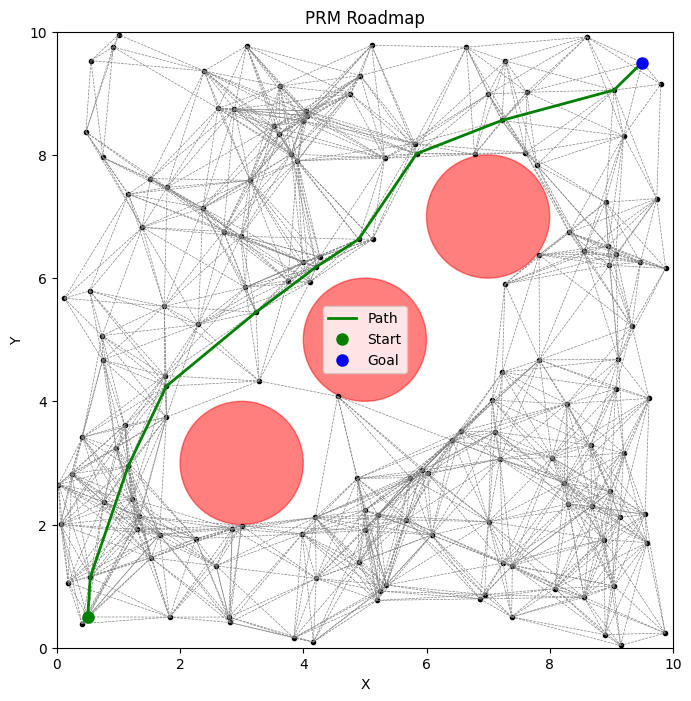

Running RRT Planner...
RRT reached goal in 120 iterations.
RRT path found with 31 nodes.


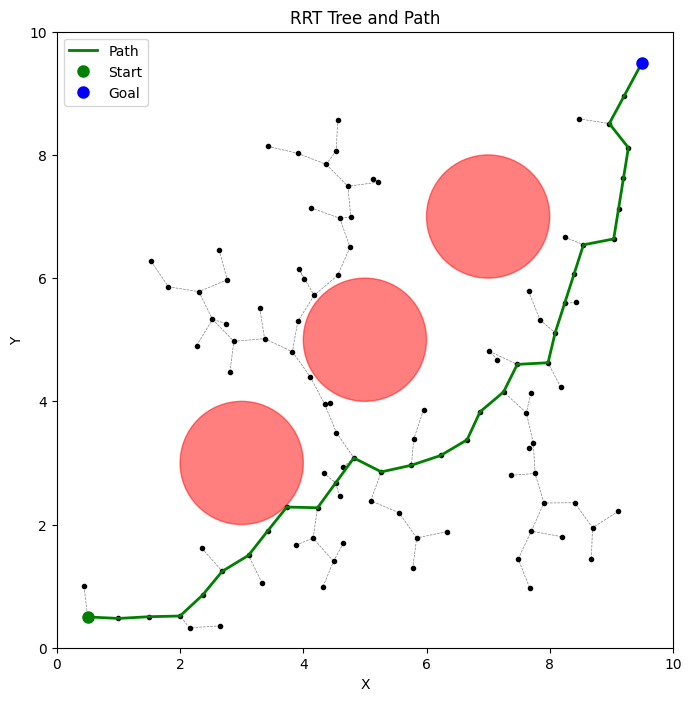

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random



# Utility: Collision checking functions for circular obstacles

def point_in_circle(point, circle):
    """Return True if the point is inside the given circular obstacle."""
    return np.linalg.norm(np.array(point) - np.array(circle['center'])) <= circle['radius']

def line_intersects_circle(p1, p2, circle):
    """
    Check if the line segment between p1 and p2 intersects a circular obstacle.
    p1, p2: (x, y) tuples.
    circle: dict with keys 'center' and 'radius'.
    """
    center = np.array(circle['center'])
    p1 = np.array(p1)
    p2 = np.array(p2)
    d = p2 - p1
    f = p1 - center

    a = np.dot(d, d)
    b = 2 * np.dot(f, d)
    c = np.dot(f, f) - circle['radius']**2

    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return False  # no intersection
    discriminant = np.sqrt(discriminant)
    t1 = (-b - discriminant) / (2 * a)
    t2 = (-b + discriminant) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1):
        return True
    return False

def is_collision_free(p1, p2, obstacles):
    """
    Check that the straight-line path between p1 and p2 does not intersect any obstacle.
    """
    for obs in obstacles:
        if line_intersects_circle(p1, p2, obs):
            return False
    return True

def is_point_free(p, obstacles):
    """Return True if the point is not inside any obstacle."""
    for obs in obstacles:
        if point_in_circle(p, obs):
            return False
    return True




# 1. Probabilistic Roadmap (PRM) Implementation

def construct_prm(num_samples, workspace, obstacles, connection_radius):
    """
    Sample free nodes and construct a roadmap.

    Parameters:
      num_samples: number of free nodes to sample.
      workspace: dict with keys 'xmin', 'xmax', 'ymin', 'ymax'.
      obstacles: list of circular obstacles.
      connection_radius: maximum distance to try to connect nodes.

    Returns:
      nodes: list of (x,y) positions.
      G: networkx Graph where edges have weight equal to Euclidean distance.
    """
    nodes = []
    xmin, xmax = workspace['xmin'], workspace['xmax']
    ymin, ymax = workspace['ymin'], workspace['ymax']

    # Randomly sample nodes and check for collisions.
    while len(nodes) < num_samples:
        p = (np.random.uniform(xmin, xmax), np.random.uniform(ymin, ymax))
        if is_point_free(p, obstacles):
            nodes.append(p)

    # Build the graph.
    G = nx.Graph()
    for i, p in enumerate(nodes):
        G.add_node(i, pos=p)
    # Connect nearby nodes with collision-free edges.
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j])) <= connection_radius:
                if is_collision_free(nodes[i], nodes[j], obstacles):
                    weight = np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j]))
                    G.add_edge(i, j, weight=weight)
    return nodes, G

def add_prm_start_goal(G, nodes, start, goal, obstacles, connection_radius):

    start_idx = len(nodes)
    nodes.append(start)
    goal_idx = len(nodes)
    nodes.append(goal)
    G.add_node(start_idx, pos=start)
    G.add_node(goal_idx, pos=goal)
    for idx in [start_idx, goal_idx]:
        for i, p in enumerate(nodes[:-2]):
            if np.linalg.norm(np.array(nodes[idx]) - np.array(p)) <= connection_radius:
                if is_collision_free(nodes[idx], p, obstacles):
                    weight = np.linalg.norm(np.array(nodes[idx]) - np.array(p))
                    G.add_edge(idx, i, weight=weight)
    return start_idx, goal_idx

def prm_planner(num_samples=150, connection_radius=2.0):
    """
    Execute PRM-based planning in a simple workspace.
    """
    # Define workspace and obstacles.
    workspace = {'xmin': 0, 'xmax': 10, 'ymin': 0, 'ymax': 10}
    obstacles = [
        {'center': (3, 3), 'radius': 1.0},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 5), 'radius': 1.0}
    ]
    start = (0.5, 0.5)
    goal = (9.5, 9.5)

    nodes, G = construct_prm(num_samples, workspace, obstacles, connection_radius)
    start_idx, goal_idx = add_prm_start_goal(G, nodes, start, goal, obstacles, connection_radius)

    # Use Dijkstra's algorithm (or A*) to search for the shortest path.
    try:
        path_indices = nx.shortest_path(G, source=start_idx, target=goal_idx, weight='weight')
        print("PRM found a path with", len(path_indices), "nodes.")
    except nx.NetworkXNoPath:
        print("PRM found no path.")
        path_indices = None

    # Visualize
    visualize_planner(nodes, G, path_indices, obstacles, workspace, method="PRM")





# 2. Rapidly-Exploring Random Tree (RRT) Implementation

def get_nearest(tree, q_rand):
    """
    Return the index and value of the tree node nearest to q_rand.
    """
    min_dist = np.inf
    nearest_idx = None
    for idx, q in tree.items():
        d = np.linalg.norm(np.array(q) - np.array(q_rand))
        if d < min_dist:
            min_dist = d
            nearest_idx = idx
    return nearest_idx, tree[nearest_idx]

def steer(q_near, q_rand, step_size):
    """
    Move from q_near toward q_rand by at most step_size.
    """
    q_near = np.array(q_near)
    q_rand = np.array(q_rand)
    direction = q_rand - q_near
    dist = np.linalg.norm(direction)
    if dist <= step_size:
        return tuple(q_rand)
    else:
        return tuple(q_near + (direction/dist)*step_size)

def rrt_planner(start, goal, obstacles, workspace, step_size=0.5, max_iter=1000, goal_sample_rate=0.1):
    """
    Implement the RRT algorithm.

    Parameters:
      start, goal: (x, y) tuples.
      obstacles: list of circular obstacles.
      workspace: dict with workspace limits.
      step_size: incremental step size for expansion.
      max_iter: maximum number of iterations.
      goal_sample_rate: probability of sampling the goal directly.

    Returns:
      tree: dictionary mapping node indices to (x,y) coordinates.
      parent: dictionary that maps child indices to the index of its parent.
      goal_idx: index of goal node if reached, else None.
    """
    tree = {}
    parent = {}
    tree[0] = start
    parent[0] = None
    node_index = 1
    for it in range(max_iter):
        # With a probability, sample the goal to bias tree growth.
        if random.random() < goal_sample_rate:
            q_rand = goal
        else:
            q_rand = (np.random.uniform(workspace['xmin'], workspace['xmax']),
                      np.random.uniform(workspace['ymin'], workspace['ymax']))
        # Skip q_rand if it is in collision.
        if not is_point_free(q_rand, obstacles):
            continue
        # Find nearest node in the tree.
        near_idx, q_near = get_nearest(tree, q_rand)
        # Steer toward q_rand.
        q_new = steer(q_near, q_rand, step_size)
        # Check collision along the edge.
        if is_collision_free(q_near, q_new, obstacles):
            tree[node_index] = q_new
            parent[node_index] = near_idx
            # Check if goal is reached.
            if np.linalg.norm(np.array(q_new) - np.array(goal)) < step_size:
                tree[node_index] = goal  # Ensure exact goal
                parent[node_index] = near_idx
                print("RRT reached goal in", it, "iterations.")
                return tree, parent, node_index
            node_index += 1
    print("RRT failed to reach goal after max iterations.")
    return tree, parent, None

def extract_rrt_path(tree, parent, goal_idx):
    """
    Reconstruct the path from start to goal in the RRT.
    """
    path = []
    idx = goal_idx
    while idx is not None:
        path.append(tree[idx])
        idx = parent[idx]
    path.reverse()
    return path

def rrt_planner_wrapper():
    """
    Run RRT planning and visualize the result.
    """
    workspace = {'xmin': 0, 'xmax': 10, 'ymin': 0, 'ymax': 10}
    obstacles = [
        {'center': (3, 3), 'radius': 1.0},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 5), 'radius': 1.0}
    ]
    start = (0.5, 0.5)
    goal = (9.5, 9.5)
    tree, parent, goal_idx = rrt_planner(start, goal, obstacles, workspace,
                                          step_size=0.5, max_iter=2000, goal_sample_rate=0.1)
    if goal_idx is not None:
        path = extract_rrt_path(tree, parent, goal_idx)
        print("RRT path found with", len(path), "nodes.")
    else:
        path = None
        print("No path was found by RRT.")
    visualize_rrt(tree, parent, path, obstacles, workspace, start, goal)




# Visualization Functions for Both Planners

def visualize_planner(nodes, G, path_indices, obstacles, workspace, method="PRM"):
    plt.figure(figsize=(8, 8))
    # Plot obstacles.
    for obs in obstacles:
        circle = plt.Circle(obs['center'], obs['radius'], color='red', alpha=0.5)
        plt.gca().add_patch(circle)
    # Plot all nodes (for PRM, sample nodes).
    ns = np.array(nodes)
    plt.plot(ns[:,0], ns[:,1], 'ko', markersize=3)
    # Plot roadmap edges.
    for (i, j) in G.edges():
        p1 = nodes[i]
        p2 = nodes[j]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', linestyle='--', linewidth=0.5)
    # Plot solution path if found.
    if path_indices is not None:
        path_coords = [nodes[i] for i in path_indices]
        xs, ys = zip(*path_coords)
        plt.plot(xs, ys, 'g-', linewidth=2, label='Path')
        plt.plot(xs[0], ys[0], 'go', markersize=8, label='Start')
        plt.plot(xs[-1], ys[-1], 'bo', markersize=8, label='Goal')
    plt.title(method + " Roadmap")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(workspace['xmin'], workspace['xmax'])
    plt.ylim(workspace['ymin'], workspace['ymax'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

def visualize_rrt(tree, parent, path, obstacles, workspace, start, goal):
    plt.figure(figsize=(8,8))
    # Plot obstacles.
    for obs in obstacles:
        circle = plt.Circle(obs['center'], obs['radius'], color='red', alpha=0.5)
        plt.gca().add_patch(circle)
    # Plot all tree edges.
    for idx, q in tree.items():
        if parent[idx] is not None:
            p_parent = tree[parent[idx]]
            plt.plot([q[0], p_parent[0]], [q[1], p_parent[1]], 'gray', linestyle='--', linewidth=0.5)
    # Plot tree nodes.
    qs = np.array(list(tree.values()))
    plt.plot(qs[:,0], qs[:,1], 'ko', markersize=3)
    # If a path exists, plot it.
    if path is not None:
        xs, ys = zip(*path)
        plt.plot(xs, ys, 'g-', linewidth=2, label='Path')
        plt.plot(start[0], start[1], 'go', markersize=8, label='Start')
        plt.plot(goal[0], goal[1], 'bo', markersize=8, label='Goal')
    plt.title("RRT Tree and Path")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(workspace['xmin'], workspace['xmax'])
    plt.ylim(workspace['ymin'], workspace['ymax'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()



# Main Function to Run and Compare PRM and RRT
def main():
    print("Running PRM Planner...")
    prm_planner(num_samples=150, connection_radius=2.0)

    print("Running RRT Planner...")
    rrt_planner_wrapper()

if __name__ == "__main__":
    main()
